# Model 2:

### Target:

- Getting the model skeleton right.
- Create a Setup (dataset, data loader, train/test steps and log plots)
- Defining a simple model with Convolution block, GAP layers.

### Results:

- Parameters: 7,272
- Best Training Accuracy: 98.45
- Best Test Accuracy: 98.58

### Analysis:

- Model with 7K parameters is able to reach till 98.58 accuracy in 15 epochs.
- Model is slightly overfitting.

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import warnings
warnings.filterwarnings("ignore")

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
from utils import load_data

train, test = load_data(train_transforms, test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


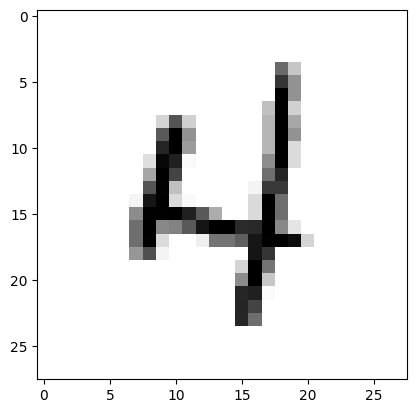

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

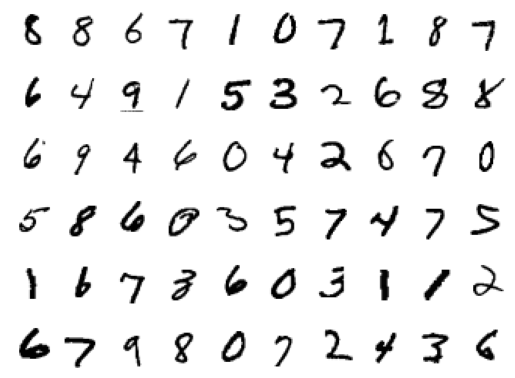

In [6]:
from utils import plot_images
plot_images(images)

# The model
Let's import our model from `model.py` file

In [7]:
from model import Model2 as Net

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5            [-1, 8, 24, 24]             128
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,152
              ReLU-9           [-1, 16, 10, 10]               0
           Conv2d-10              [-1, 8, 8, 8]           1,152
             ReLU-11              [-1, 8, 8, 8]               0
           Conv2d-12             [-1, 16, 6, 6]           1,152
             ReLU-13             [-1, 16, 6, 6]               0
           Conv2d-14             [

# Training and Testing
Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's import train and test functions from `model.py` file

In [9]:
from model import train, test

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    test(model, device, test_loader, test_losses, test_acc)

EPOCH: 0


Loss=2.302196502685547 Batch_id=468 Accuracy=10.16: 100%|████████████████████████████| 469/469 [00:07<00:00, 65.96it/s]



Test set: Average loss: 2.3022, Accuracy: 1015/10000 (10.15%)

EPOCH: 1


Loss=0.8686118721961975 Batch_id=468 Accuracy=17.69: 100%|███████████████████████████| 469/469 [00:05<00:00, 84.91it/s]



Test set: Average loss: 0.7435, Accuracy: 7680/10000 (76.80%)

EPOCH: 2


Loss=0.14543817937374115 Batch_id=468 Accuracy=88.72: 100%|██████████████████████████| 469/469 [00:05<00:00, 84.38it/s]



Test set: Average loss: 0.1597, Accuracy: 9517/10000 (95.17%)

EPOCH: 3


Loss=0.11306346207857132 Batch_id=468 Accuracy=95.05: 100%|██████████████████████████| 469/469 [00:05<00:00, 84.64it/s]



Test set: Average loss: 0.1120, Accuracy: 9668/10000 (96.68%)

EPOCH: 4


Loss=0.10961988568305969 Batch_id=468 Accuracy=96.58: 100%|██████████████████████████| 469/469 [00:05<00:00, 83.40it/s]



Test set: Average loss: 0.1025, Accuracy: 9690/10000 (96.90%)

EPOCH: 5


Loss=0.03896281123161316 Batch_id=468 Accuracy=97.02: 100%|██████████████████████████| 469/469 [00:05<00:00, 83.51it/s]



Test set: Average loss: 0.0789, Accuracy: 9765/10000 (97.65%)

EPOCH: 6


Loss=0.04126615449786186 Batch_id=468 Accuracy=97.40: 100%|██████████████████████████| 469/469 [00:05<00:00, 86.55it/s]



Test set: Average loss: 0.0991, Accuracy: 9700/10000 (97.00%)

EPOCH: 7


Loss=0.02958519570529461 Batch_id=468 Accuracy=97.52: 100%|██████████████████████████| 469/469 [00:05<00:00, 85.34it/s]



Test set: Average loss: 0.0701, Accuracy: 9767/10000 (97.67%)

EPOCH: 8


Loss=0.06657395511865616 Batch_id=468 Accuracy=97.78: 100%|██████████████████████████| 469/469 [00:05<00:00, 86.04it/s]



Test set: Average loss: 0.0595, Accuracy: 9810/10000 (98.10%)

EPOCH: 9


Loss=0.13110901415348053 Batch_id=468 Accuracy=97.99: 100%|██████████████████████████| 469/469 [00:05<00:00, 80.77it/s]



Test set: Average loss: 0.0589, Accuracy: 9816/10000 (98.16%)

EPOCH: 10


Loss=0.03627697005867958 Batch_id=468 Accuracy=98.05: 100%|██████████████████████████| 469/469 [00:05<00:00, 85.93it/s]



Test set: Average loss: 0.0687, Accuracy: 9779/10000 (97.79%)

EPOCH: 11


Loss=0.042963072657585144 Batch_id=468 Accuracy=98.18: 100%|█████████████████████████| 469/469 [00:05<00:00, 84.45it/s]



Test set: Average loss: 0.0526, Accuracy: 9827/10000 (98.27%)

EPOCH: 12


Loss=0.019602863118052483 Batch_id=468 Accuracy=98.37: 100%|█████████████████████████| 469/469 [00:05<00:00, 84.57it/s]



Test set: Average loss: 0.0604, Accuracy: 9824/10000 (98.24%)

EPOCH: 13


Loss=0.06540149450302124 Batch_id=468 Accuracy=98.41: 100%|██████████████████████████| 469/469 [00:05<00:00, 83.09it/s]



Test set: Average loss: 0.0442, Accuracy: 9858/10000 (98.58%)

EPOCH: 14


Loss=0.07266172021627426 Batch_id=468 Accuracy=98.45: 100%|██████████████████████████| 469/469 [00:05<00:00, 84.43it/s]



Test set: Average loss: 0.0503, Accuracy: 9839/10000 (98.39%)



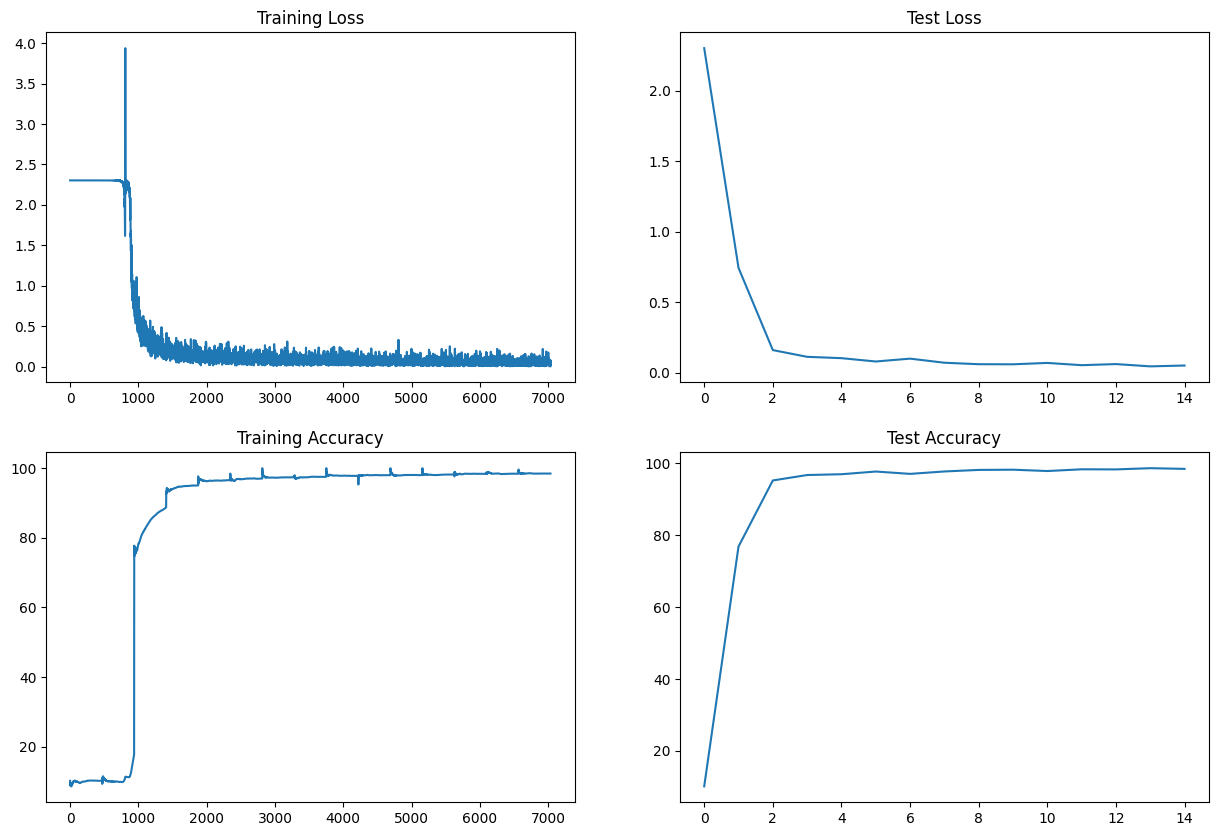

In [11]:
from utils import plot_graphs

plot_graphs(train_acc, train_losses, test_acc, test_losses)